In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [2]:
df = pd.read_csv('ipl.csv')
df.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [3]:
cols_to_drop = ['mid','batsman','bowler','striker','non-striker']
df.drop(cols_to_drop,axis=1,inplace=True)
df.head()

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


In [4]:
# convert the date column to datetime column
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))


# we have to remove temporary teams or the teams which are not available now
consistent_teams = ['Chennai Super Kings', 'Delhi Daredevils', 
                    'Kings XI Punjab', 'Kolkata Knight Riders', 
                    'Mumbai Indians', 'Rajasthan Royals', 
                    'Royal Challengers Bangalore', 'Sunrisers Hyderabad']

df = df[(df['bat_team'].isin(consistent_teams)) & (df['bowl_team'].isin(consistent_teams))]


# we don't want first five overs data
df = df[df['overs']>=5.0]

df.head()

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
32,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,0,5.1,59,0,222
33,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.2,59,1,222
34,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.3,59,1,222
35,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.4,59,1,222
36,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.5,58,1,222


In [5]:
df['venue'].unique()

array(['M Chinnaswamy Stadium',
       'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
       'Wankhede Stadium', 'Sawai Mansingh Stadium',
       'MA Chidambaram Stadium, Chepauk', 'Eden Gardens',
       'Dr DY Patil Sports Academy', 'Newlands', "St George's Park",
       'Kingsmead', 'SuperSport Park', 'Buffalo Park',
       'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera',
       'Himachal Pradesh Cricket Association Stadium',
       'Subrata Roy Sahara Stadium',
       'Rajiv Gandhi International Stadium, Uppal',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sheikh Zayed Stadium',
       'Sharjah Cricket Stadium', 'Dubai International Cricket Stadium',
       'Barabati Stadium', 'Maharashtra Cricket Association Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Punjab Cricket Association IS Bi

In [6]:
def f(x):
    if x=='M Chinnaswamy Stadium':
        return 'M Chinnaswamy Stadium, Bangalore'
    elif x=='Feroz Shah Kotla':
        return 'Feroz Shah Kotla, Delhi'
    elif x=='Wankhede Stadium':
        return 'Wankhede Stadium, Mumbai'
    elif x=='Sawai Mansingh Stadium':
        return 'Sawai Mansingh Stadium, Jaipur'
    elif x=='Eden Gardens':
        return 'Eden Gardens, Kolkata'
    elif x=='Dr DY Patil Sports Academy':
        return 'Dr DY Patil Sports Academy, Mumbai'
    elif x=='Himachal Pradesh Cricket Association Stadium':
        return 'Himachal Pradesh Cricket Association Stadium, Dharamshala'
    elif x=='Subrata Roy Sahara Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Shaheed Veer Narayan Singh International Stadium':
        return 'Raipur International Cricket Stadium, Raipur'
    elif x=='JSCA International Stadium Complex':
        return 'JSCA International Stadium Complex, Ranchi'
    elif x=='Maharashtra Cricket Association Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium':
        return 'ACA-VDCA Stadium, Visakhapatnam'
    elif x=='Punjab Cricket Association IS Bindra Stadium, Mohali':
        return 'Punjab Cricket Association Stadium, Mohali'
    elif x=='Holkar Cricket Stadium':
        return 'Holkar Cricket Stadium, Indore'
    elif x=='Sheikh Zayed Stadium':
        return 'Sheikh Zayed Stadium, Abu-Dhabi'
    elif x=='Sharjah Cricket Stadium':
        return 'Sharjah Cricket Stadium, Sharjah'
    elif x=='Dubai International Cricket Stadium':
        return 'Dubai International Cricket Stadium, Dubai'
    elif x=='Barabati Stadium':
        return 'Barabati Stadium, Cuttack'
    else:
        return x

ignored_stadiums = ['Newlands', "St George's Park",
                    'Kingsmead', 'SuperSport Park', 'Buffalo Park',
                    'New Wanderers Stadium', 'De Beers Diamond Oval',
                    'OUTsurance Oval', 'Brabourne Stadium']

df = df[True^(df['venue'].isin(ignored_stadiums))]
df['venue'] = df['venue'].apply(f)
df.head()

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
32,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,0,5.1,59,0,222
33,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.2,59,1,222
34,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.3,59,1,222
35,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.4,59,1,222
36,2008-04-18,"M Chinnaswamy Stadium, Bangalore",Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.5,58,1,222


In [7]:
df_new = pd.get_dummies(data=df,columns=['venue','bat_team','bowl_team'])
df_new.head()

,date,runs,wickets,overs,runs_last_5,wickets_last_5,total,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai",...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
32,2008-04-18,61,0,5.1,59,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
33,2008-04-18,61,1,5.2,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,2008-04-18,61,1,5.3,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
35,2008-04-18,61,1,5.4,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36,2008-04-18,61,1,5.5,58,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
df_new.columns

Index(['date', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5',
       'total', 'venue_ACA-VDCA Stadium, Visakhapatnam',
       'venue_Barabati Stadium, Cuttack',
       'venue_Dr DY Patil Sports Academy, Mumbai',
       'venue_Dubai International Cricket Stadium, Dubai',
       'venue_Eden Gardens, Kolkata', 'venue_Feroz Shah Kotla, Delhi',
       'venue_Himachal Pradesh Cricket Association Stadium, Dharamshala',
       'venue_Holkar Cricket Stadium, Indore',
       'venue_JSCA International Stadium Complex, Ranchi',
       'venue_M Chinnaswamy Stadium, Bangalore',
       'venue_MA Chidambaram Stadium, Chepauk',
       'venue_Maharashtra Cricket Association Stadium, Pune',
       'venue_Punjab Cricket Association Stadium, Mohali',
       'venue_Raipur International Cricket Stadium, Raipur',
       'venue_Rajiv Gandhi International Stadium, Uppal',
       'venue_Sardar Patel Stadium, Motera',
       'venue_Sawai Mansingh Stadium, Jaipur',
       'venue_Sharjah Cricket Stadi

In [9]:
df_new = df_new[['date','venue_ACA-VDCA Stadium, Visakhapatnam',
       'venue_Barabati Stadium, Cuttack', 'venue_Dr DY Patil Sports Academy, Mumbai',
       'venue_Dubai International Cricket Stadium, Dubai',
       'venue_Eden Gardens, Kolkata', 'venue_Feroz Shah Kotla, Delhi',
       'venue_Himachal Pradesh Cricket Association Stadium, Dharamshala',
       'venue_Holkar Cricket Stadium, Indore',
       'venue_JSCA International Stadium Complex, Ranchi',
       'venue_M Chinnaswamy Stadium, Bangalore',
       'venue_MA Chidambaram Stadium, Chepauk',
       'venue_Maharashtra Cricket Association Stadium, Pune',
       'venue_Punjab Cricket Association Stadium, Mohali',
       'venue_Raipur International Cricket Stadium, Raipur',
       'venue_Rajiv Gandhi International Stadium, Uppal',
       'venue_Sardar Patel Stadium, Motera',
       'venue_Sawai Mansingh Stadium, Jaipur',
       'venue_Sharjah Cricket Stadium, Sharjah',
       'venue_Sheikh Zayed Stadium, Abu-Dhabi',
       'venue_Wankhede Stadium, Mumbai','bat_team_Chennai Super Kings',
       'bat_team_Delhi Daredevils', 'bat_team_Kings XI Punjab',
       'bat_team_Kolkata Knight Riders', 'bat_team_Mumbai Indians',
       'bat_team_Rajasthan Royals', 'bat_team_Royal Challengers Bangalore',
       'bat_team_Sunrisers Hyderabad','bowl_team_Chennai Super Kings',
       'bowl_team_Delhi Daredevils', 'bowl_team_Kings XI Punjab',
       'bowl_team_Kolkata Knight Riders', 'bowl_team_Mumbai Indians',
       'bowl_team_Rajasthan Royals', 'bowl_team_Royal Challengers Bangalore',
       'bowl_team_Sunrisers Hyderabad','runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5',
       'total']]
df_new.head()

,date,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi",...,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5,total
32,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,0,5.1,59,0,222
33,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.2,59,1,222
34,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.3,59,1,222
35,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.4,59,1,222
36,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.5,58,1,222


In [10]:
df_new.reset_index(inplace=True)
df_new.drop('index',inplace=True,axis=1)
df_new

,date,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi",...,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,0,5.1,59,0,222
1,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.2,59,1,222
2,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.3,59,1,222
3,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.4,59,1,222
4,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.5,58,1,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35646,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,106,9,18.1,29,4,107
35647,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,9,18.2,29,4,107
35648,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,9,18.3,28,4,107
35649,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,9,18.4,24,4,107


In [11]:
scaler = StandardScaler()

scaled_cols = scaler.fit_transform(df_new[['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5']])
scaled_cols = pd.DataFrame(scaled_cols,columns=['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'])

df_new.drop(['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'],axis=1,inplace=True)
df_new = pd.concat([df_new,scaled_cols],axis=1)

df_new

,date,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi",...,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,total,runs,wickets,overs,runs_last_5,wickets_last_5
0,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832372,-1.590613,-1.667664,1.713851,-1.233715
1,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832372,-1.062418,-1.644520,1.713851,-0.294064
2,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832372,-1.062418,-1.621376,1.713851,-0.294064
3,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832372,-1.062418,-1.598232,1.713851,-0.294064
4,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832372,-1.062418,-1.575088,1.627459,-0.294064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35646,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,0.257403,3.163135,1.341046,-0.877910,2.524889
35647,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,0.281621,3.163135,1.364190,-0.877910,2.524889
35648,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,0.281621,3.163135,1.387333,-0.964302,2.524889
35649,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,0.281621,3.163135,1.410477,-1.309870,2.524889


In [12]:
X_train = df_new.drop('total',axis=1)[df_new['date'].dt.year<=2016]
X_test = df_new.drop('total',axis=1)[df_new['date'].dt.year>=2017]

X_train.drop('date',inplace=True,axis=1)
X_test.drop('date',inplace=True,axis=1)


y_train = df_new[df_new['date'].dt.year<=2016]['total'].values
y_test = df_new[df_new['date'].dt.year>=2017]['total'].values

In [13]:
X_train

,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi","venue_M Chinnaswamy Stadium, Bangalore",...,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.590613,-1.667664,1.713851,-1.233715
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.062418,-1.644520,1.713851,-0.294064
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.062418,-1.621376,1.713851,-0.294064
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.062418,-1.598232,1.713851,-0.294064
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.832372,-1.062418,-1.575088,1.627459,-0.294064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32868,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.388520,2.106747,1.595629,1.281891,2.524889
32869,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.533823,2.106747,1.618773,1.454675,2.524889
32870,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.558041,2.106747,1.641917,1.454675,2.524889
32871,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.582258,2.106747,1.665060,1.541067,2.524889


# Ridge Classifier

{'alpha': 40}
-346.861331818924


MAE: 12.36142320381114
MSE: 266.5646484438164
RMSE: 16.32680766236365


r2 score of ridge : 0.7369093754948086


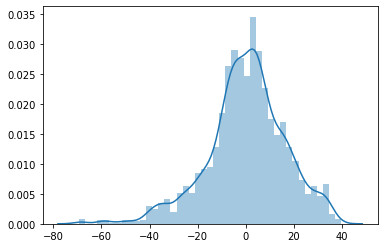

In [14]:
ridge = Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
ridge_regressor = RandomizedSearchCV(ridge,parameters,cv=10,scoring='neg_mean_squared_error')
ridge_regressor.fit(X_train,y_train)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

print('\n')

prediction_r = ridge_regressor.predict(X_test)
print('MAE:', mean_absolute_error(y_test, prediction_r))
print('MSE:', mean_squared_error(y_test, prediction_r))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction_r)))

print('\n')

print(f'r2 score of ridge : {r2_score(y_test,prediction_r)}')

sns.distplot(y_test-prediction_r)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260944.38195421174, tolerance: 2539.3331996619913
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 506903.43491074257, tolerance: 2625.527772026364
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481147.3002448147, tolerance: 2555.4237792597587
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

{'alpha': 0.01}
-347.7308487883935


MAE: 12.298156691182788
MSE: 263.7447252397693
RMSE: 16.240219371663958


r2 score of ridge : 0.7396925478364547


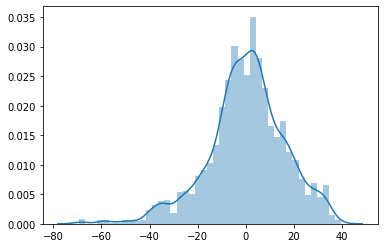

In [15]:
lasso = Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_regressor = RandomizedSearchCV(lasso,parameters,cv=10,scoring='neg_mean_squared_error')
lasso_regressor.fit(X_train,y_train)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

print('\n')

prediction_r = lasso_regressor.predict(X_test)
print('MAE:', mean_absolute_error(y_test, prediction_r))
print('MSE:', mean_squared_error(y_test, prediction_r))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction_r)))

print('\n')

print(f'r2 score of ridge : {r2_score(y_test,prediction_r)}')

sns.distplot(y_test-prediction_r)

In [16]:
joblib.dump(ridge_regressor,'iplmodel_ridge.sav')

['iplmodel_ridge.sav']

In [17]:
from flask import Flask,render_template,request
import numpy as np
import joblib

regressor = joblib.load('iplmodel_ridge.sav')

app = Flask(__name__)


@app.route('/')
def home():
    return render_template('home.html',val='')

@app.route('/predict',methods=['POST'])
def predict():

    a = []

    if request.method == 'POST':

        venue = request.form['venue']
        if venue=='ACA-VDCA Stadium, Visakhapatnam':
            a = a + [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='Barabati Stadium, Cuttack':
            a = a + [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='Dr DY Patil Sports Academy, Mumbai':
            a = a + [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='Dubai International Cricket Stadium, Dubai':
            a = a + [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='Eden Gardens, Kolkata':
            a = a + [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='Feroz Shah Kotla, Delhi':
            a = a + [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='Himachal Pradesh Cricket Association Stadium, Dharamshala':
            a = a + [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='Holkar Cricket Stadium, Indore':
            a = a + [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='JSCA International Stadium Complex, Ranchi':
            a = a + [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]

        elif venue=='M Chinnaswamy Stadium, Bangalore':
            a = a + [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]

        elif venue=='MA Chidambaram Stadium, Chepauk':
            a = a + [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]

        elif venue=='Maharashtra Cricket Association Stadium, Pune':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]

        elif venue=='Punjab Cricket Association Stadium, Mohali':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]

        elif venue=='Raipur International Cricket Stadium, Raipur':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]

        elif venue=='Rajiv Gandhi International Stadium, Uppal':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]

        elif venue=='Sardar Patel Stadium, Motera':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]

        elif venue=='Sawai Mansingh Stadium, Jaipur':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]

        elif venue=='Sharjah Cricket Stadium, Sharjah':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]

        elif venue=='Sheikh Zayed Stadium, Abu-Dhabi':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
            
        elif venue=='Wankhede Stadium, Mumbai':
            a = a + [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
            
  
        batting_team = request.form['batting-team']
        if batting_team == 'Chennai Super Kings':
            a = a + [1,0,0,0,0,0,0,0]
        elif batting_team == 'Delhi Capitals':
            a = a + [0,1,0,0,0,0,0,0]
        elif batting_team == 'Kings XI Punjab':
            a = a + [0,0,1,0,0,0,0,0]
        elif batting_team == 'Kolkata Knight Riders':
            a = a + [0,0,0,1,0,0,0,0]
        elif batting_team == 'Mumbai Indians':
            a = a + [0,0,0,0,1,0,0,0]
        elif batting_team == 'Rajasthan Royals':
            a = a + [0,0,0,0,0,1,0,0]
        elif batting_team == 'Royal Challengers Bangalore':
            a = a + [0,0,0,0,0,0,1,0]
        elif batting_team == 'Sunrisers Hyderabad':
            a = a + [0,0,0,0,0,0,0,1]
        

        bowling_team = request.form['bowling-team']
        if bowling_team == 'Chennai Super Kings':
            a = a + [1,0,0,0,0,0,0,0]
        elif bowling_team == 'Delhi Capitals':
            a = a + [0,1,0,0,0,0,0,0]
        elif bowling_team == 'Kings XI Punjab':
            a = a + [0,0,1,0,0,0,0,0]
        elif bowling_team == 'Kolkata Knight Riders':
            a = a + [0,0,0,1,0,0,0,0]
        elif bowling_team == 'Mumbai Indians':
            a = a + [0,0,0,0,1,0,0,0]
        elif bowling_team == 'Rajasthan Royals':
            a = a + [0,0,0,0,0,1,0,0]
        elif bowling_team == 'Royal Challengers Bangalore':
            a = a + [0,0,0,0,0,0,1,0]
        elif bowling_team == 'Sunrisers Hyderabad':
            a = a + [0,0,0,0,0,0,0,1]

        if batting_team==bowling_team and batting_team!='none' and bowling_team!='none':
            return render_template('home.html',val='Batting team and Bowling team cant be same and none of the values can\'t be empty.')



        overs = request.form['overs']
        runs = request.form['runs']
        wickets = request.form['wickets']
        runs_in_prev_5 = request.form['runs_in_prev_5']
        wickets_in_prev_5 = request.form['wickets_in_prev_5']

        if overs=='' or runs=='' or wickets=='' or runs_in_prev_5=='' or wickets_in_prev_5=='':
            return render_template('home.html',val='You can\'t leave any field empty!!!')

        overs = float(overs)
        runs = int(runs)
        wickets = int(wickets)
        runs_in_prev_5 = int(runs_in_prev_5)
        wickets_in_prev_5 = int(wickets_in_prev_5)


        a = a + [runs, wickets, overs, runs_in_prev_5, wickets_in_prev_5]

        data = np.array([a])
        my_prediction = int(regressor.predict(data)[0])
        print(my_prediction)

        return render_template('home.html', val=f'The final score will be around {my_prediction-5} to {my_prediction+10}.')


if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
